In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoConfig
from datasets import load_dataset
import soundfile
import librosa
from transformers import ASTConfig, ASTModel

#from dask import delayed, compute
#from dask.distributed import Client

/home/cymberly/miniconda3/envs/multifunc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation", trust_remote_code=True)
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

inputs = feature_extractor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
print(inputs['input_values'].shape)
#print(**inputs)
with torch.no_grad():
    #logits = model(**inputs).logits
    logits = model(inputs["input_values"]).logits

print(logits.shape)

predicted_class_ids = torch.argmax(logits, dim=-1).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

target_label = model.config.id2label[0]
inputs["labels"] = torch.tensor([model.config.label2id[target_label]])
loss = model(**inputs).loss
round(loss.item(), 2)

/home/cymberly/miniconda3/envs/multifunc/lib/python3.11/site-packages/transformers/audio_utils.py:297: UserWarning: At least one mel filter has all zero values. The value for `num_mel_filters` (128) may be set too high. Or, the value for `num_frequency_bins` (256) may be set too low.
  warnings.warn(


torch.Size([1, 1024, 128])


In [3]:
high = 1
low = -1
sample_size = 10000
sequence_size = 1000
degree = 3
x = torch.linspace(-1, 1, sequence_size)
x = x.unsqueeze(1).expand(sequence_size, sample_size)
y = torch.zeros_like(x)
for n in range(degree):
    p = (high - low) * torch.rand(sample_size)
    y += p*(x**(n+1))

#plt.plot(x[:,0], y[:,0]);
print(y.shape)

torch.Size([1000, 10000])


In [15]:
'''y_np = y.numpy()
y_np = y_np/np.max(np.abs(y_np))
sample_y = y_np[:, 0]
D = librosa.stft(sample_y, n_fft=2032, hop_length=4)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
spectrogram = np.expand_dims(S_db, axis=0)
spectrogram = torch.tensor(spectrogram).to(device)
print(spectrogram.shape)'''

torch.Size([1, 1017, 251])


/home/cymberly/miniconda3/envs/multifunc/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2032 is too large for input signal of length=1000
  warnings.warn(


In [4]:
def to_spectrogram(data, n_fft=2032, hop_length=4):
    D = librosa.stft(data, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    spectrogram = np.expand_dims(S_db, axis=0)
    return torch.tensor(spectrogram)

y_np = y.numpy().swapaxes(0,1)
y_np = y_np/np.max(np.abs(y_np))

'''spectrograms = [to_spectrogram(s) for s in y_np]
full_data = torch.vstack(spectrograms).to(device)
print(full_data.shape)'''

'spectrograms = [to_spectrogram(s) for s in y_np]\nfull_data = torch.vstack(spectrograms).to(device)\nprint(full_data.shape)'

In [5]:
dataloader = DataLoader(y_np, batch_size=100)

In [6]:
from tqdm import tqdm

In [7]:
all_spectrograms = []

for batch in tqdm(dataloader):
    batch = batch.numpy()
    batch_spectrograms = [to_spectrogram(s) for s in batch]
    batch_tensor = torch.vstack(batch_spectrograms)
    all_spectrograms.append(batch_tensor)    

  0%|          | 0/100 [00:00<?, ?it/s]/home/cymberly/miniconda3/envs/multifunc/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2032 is too large for input signal of length=1000
  warnings.warn(
100%|██████████| 100/100 [07:13<00:00,  4.34s/it]


In [11]:
print(len(all_spectrograms))
data = torch.vstack(all_spectrograms).to(device)
data.shape

100


torch.Size([10000, 1017, 251])

In [12]:
torch.save(data, 'spectrogram_data.pt')

In [3]:
data = torch.load('spectrogram_data.pt')

/tmp/ipykernel_552920/4098331274.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('spectrogram_data.pt')


In [4]:
data.shape

torch.Size([10000, 1017, 251])

In [12]:
'''num_samples = y_np.shape[1]
batch_size = 1
all_spectrograms = []

for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    batch = y_np[:, start:end]
    batch_spectrograms = [to_spectrogram(s) for s in batch.T]
    batch_tensor = torch.vstack(batch_spectrograms).to(device)
    all_spectrograms.append(batch_tensor)

full_data = torch.cat(all_spectrograms, dim=0)
full_data.shape'''

'num_samples = y_np.shape[1]\nbatch_size = 1\nall_spectrograms = []\n\nfor start in range(0, num_samples, batch_size):\n    end = min(start + batch_size, num_samples)\n    batch = y_np[:, start:end]\n    batch_spectrograms = [to_spectrogram(s) for s in batch.T]\n    batch_tensor = torch.vstack(batch_spectrograms).to(device)\n    all_spectrograms.append(batch_tensor)\n\nfull_data = torch.cat(all_spectrograms, dim=0)\nfull_data.shape'

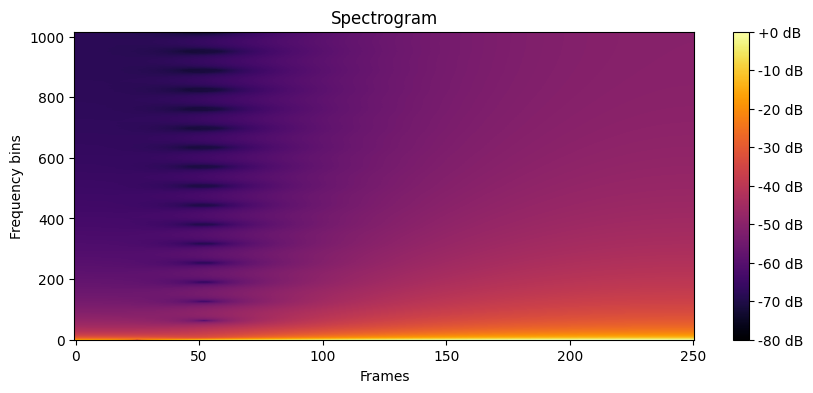

In [18]:
r = np.random.randint(1000)
spectrogram_np = data[r].cpu().numpy().squeeze()

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_np, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Frames')
plt.ylabel('Frequency bins')
plt.show()

In [19]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        return torch.zeros_like(params)

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 2:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)

def cubic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 3:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)
    
def sin_function(params, x, device):
    x = x.to(device)
    if params.size(1) == 3:
        amplitude = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        frequency = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        phase = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        return amplitude * torch.sin(2 * torch.pi * frequency * x + phase)
    else:
        return torch.zeros_like(x)

In [8]:
def new_loss(output, target, x):
    derivative_true = torch.autograd.grad(outputs=target.requires_grad_(True), inputs=x, grad_outputs=torch.ones_like(target), allow_unused=True)[0]
    if derivative_true is None:
        derivative_true = torch.zeros_like(output)
    derivative_pred = (torch.roll(output, shifts=-1, dims=0) - torch.roll(output, shifts=1, dims=0)) / (2 * 1e-8)
    mse_function = torch.mean(torch.abs(target - output)**3)
    mse_derivative = torch.mean(torch.abs(derivative_pred - derivative_true)**3)
    return mse_function + mse_derivative

torch.Size([1000])
torch.Size([1, 129, 8])
torch.Size([1, 129, 8])
1032


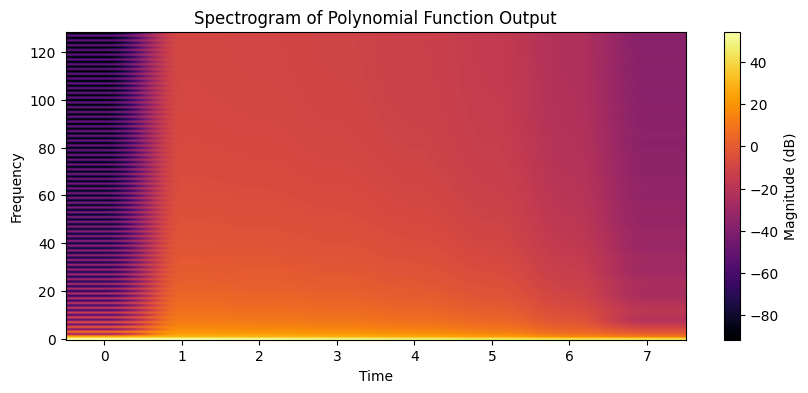

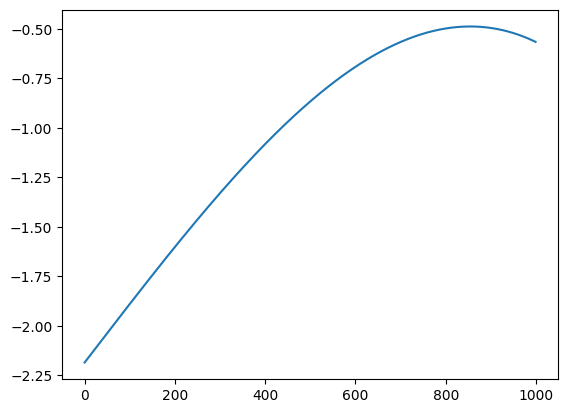

In [53]:
'''r = np.random.randint(sample_size)
sample = data[r, :, 0]
print(sample.shape)
# STFT parameters
n_fft = 256  # Number of FFT components
win_length = 256  # Window length
hop_length = 128  # Number of samples between frames

# Convert sample to complex tensor with the required dimensions
sample = sample.unsqueeze(0)  # Add batch dimension

# Apply STFT
spectrogram = torch.stft(sample, n_fft=n_fft, win_length=win_length, hop_length=hop_length, return_complex=True)
print(spectrogram.shape)
# Compute magnitude spectrogram
magnitude_spectrogram = torch.abs(spectrogram)
print(magnitude_spectrogram.shape)

# Convert to numpy for plotting
spectrogram_np = magnitude_spectrogram.squeeze().cpu().numpy()
print(spectrogram_np.size)
# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(20 * np.log10(spectrogram_np + 1e-8), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram of Polynomial Function Output')
plt.show()

plt.plot(data[r, :, 0].detach().cpu().numpy(), "-");
'''

In [12]:
'''import torch.nn.functional as F

def compute_spectrogram(data, n_fft=2032, win_length=2032, hop_length=32):
    data = data.squeeze(1).unsqueeze(0)
    spectrogram = torch.stft(data, n_fft=n_fft, win_length=win_length, hop_length=hop_length, return_complex=True)
    magnitude_spectrogram = torch.abs(spectrogram)
    return magnitude_spectrogram

spectrograms = [compute_spectrogram(sample) for sample in data]
spectrograms_np = [s.cpu().numpy() for s in spectrograms]

new_data = torch.vstack(spectrograms)

new_data.shape'''

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (1016, 1016) at dimension 2 of input [1, 1, 1000]

(1, 129, 16)


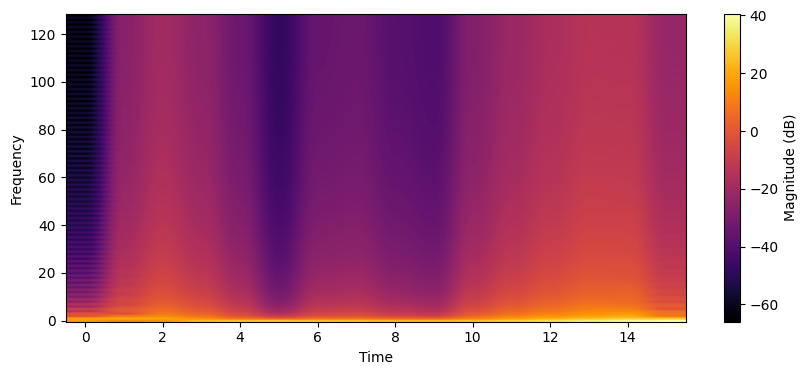

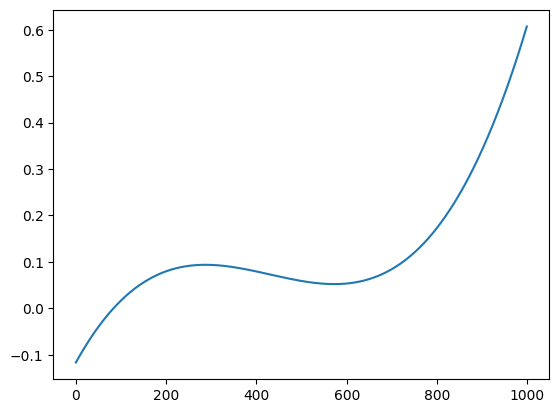

In [11]:
'''plt.figure(figsize=(10, 4))
r = np.random.randint(100)
print(spectrograms_np[r].shape)
#if len(spectrograms_np.shape) == 3:
#        spectrogram_np = np.mean(spectrograms_np, axis=0)  # Average over batch_size if necessary

plt.imshow(20 * np.log10(np.mean(spectrograms_np[r], axis=0) + 1e-8), aspect='auto', origin='lower', cmap='inferno')
#plt.imshow(spectrograms_np[r], aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()
plt.plot(data[r].detach().cpu().numpy(), "-");'''

In [10]:
'''class ASTPatchEmbeddings(nn.Module):
    def __init__(self, input_channels=8, output_channels=768, kernel_size=(16, 16), stride=(10, 10)):
        super(ASTPatchEmbeddings, self).__init__()
        self.projection = nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride)
        self.dropout = nn.Dropout(p=0.0)

    def forward(self, x):
        x = self.projection(x)
        x = self.dropout(x)
        return x

class ASTEmbeddings(nn.Module):
    def __init__(self, input_channels=8, output_channels=768, kernel_size=(16, 16), stride=(10, 10)):
        super(ASTEmbeddings, self).__init__()
        self.patch_embeddings = ASTPatchEmbeddings(input_channels, output_channels, kernel_size, stride)
        output_height = (40000 - kernel_size[0]) // stride[0] + 1
        output_width = (129 - kernel_size[1]) // stride[1] + 1
        self.position_embeddings = nn.Parameter(torch.zeros(1, output_channels, output_height, output_width))
        self.dropout = nn.Dropout(p=0.0)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

class ASTModel(nn.Module):
    def __init__(self, config):
        super(ASTModel, self).__init__()
        self.embeddings = ASTEmbeddings(
            input_channels=config.input_values[2],  
            output_channels=768,  
            kernel_size=(16, 16),
            stride=(10, 10)
        )

    def forward(self, input_values):
        x = self.embeddings(input_values)
        return x

class ASTConfig:
    def __init__(self, input_values):
        self.input_values = input_values

config = ASTConfig(input_values=(40000, 129, 8))
customModel = ASTModel(config).to(device)

new_data = new_data.permute(2,0,1).unsqueeze(0)
outs = customModel(new_data)'''

In [20]:
class CustomModel(ASTForAudioClassification):
    def __init__(self, config):
        super().__init__(config)
        
        # Remove the last dense layer
        del self.classifier.dense

    def forward(self, input_values):
        # Forward pass through the transformer layers
        outputs = self.audio_spectrogram_transformer(input_values)
        
        # Apply layer normalization
        output = self.classifier.layernorm(outputs[0])
        
        # Instead of the dense layer, return the features
        return output

In [21]:
#config = AutoConfig.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')
config = ASTConfig()#input_values=(40000, 128, 8))
customModel = CustomModel(config).to(device)
#customModel = OtherCustomModel().to(device)

In [22]:
customModel.train
print(data[0].unsqueeze(0).shape)
outs = customModel(data[0].unsqueeze(0))
print(outs.shape)

torch.Size([1, 1017, 251])


RuntimeError: The size of tensor a (2426) must match the size of tensor b (1214) at non-singleton dimension 1

In [13]:
customModel.train
print(full_data[0].unsqueeze(0).shape)
outs = customModel(full_data[0].unsqueeze(0))
print(outs.shape)

torch.Size([1, 1017, 251])


RuntimeError: The size of tensor a (2426) must match the size of tensor b (1214) at non-singleton dimension 1

In [12]:
customModel.train
print(full_data.shape)
outs = customModel(full_data)
print(outs.shape)

torch.Size([100, 1017, 251])


RuntimeError: The size of tensor a (2426) must match the size of tensor b (1214) at non-singleton dimension 1

In [26]:
dummyData = torch.zeros((1, 1017, 128)).to(device)
print(dummyData.shape)
customModel(dummyData)

torch.Size([1, 1017, 128])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:4',
       grad_fn=<NativeLayerNormBackward0>)

In [16]:
'''customModel.train
# outs = customModel(new_data.to(device))
print(new_data[0].unsqueeze(0).shape)
customModel(new_data[0].unsqueeze(0))'''

torch.Size([1, 129, 16])


RuntimeError: The size of tensor a (14) must match the size of tensor b (1214) at non-singleton dimension 1

In [16]:
'''with torch.no_grad():
    logits = customModel(new_data.to(device)).logits

print(logits.shape)'''

RuntimeError: The size of tensor a (14) must match the size of tensor b (1214) at non-singleton dimension 1

In [66]:
'''from transformers import ASTConfig, ASTModel

class OtherCustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.audio_spectrogram_transformer = ASTModel(
            config=ASTConfig(
                input_values=(40000, 129, 8),
                patch_size=
            )
        )
        #del self.classifier.dense

    def forward(self, input_values):
        outputs = self.audio_spectrogram_transformer(input_values)
        output = self.audio_spectrogram_transformer.classifier.layernorm(outputs[0])
        return output

'''

In [39]:
'''customModel.train
test_outs = customModel(inputs["input_values"].to(device))'''

In [22]:
'''# Define dimensions
num_time_steps = 10000
num_mel_bins = 128
num_channels = 8

# Generate linear polynomial data
# For simplicity, we'll generate data where each channel is a linear function of the time step

# Create a linearly increasing array for each channel
linear_pattern = np.linspace(start=0, stop=1, num=num_time_steps)

# Stack and reshape to fit [40000, 129, 8] dimensions
# For each mel bin, apply a linear polynomial across the time steps and channels
data = np.zeros((num_time_steps, num_mel_bins, num_channels))

for mel_bin in range(num_mel_bins):
    for channel in range(num_channels):
        data[:, mel_bin, channel] = linear_pattern * (mel_bin + 1) * (channel + 1)

print(data.shape)  # Should print: (40000, 129, 8)
'''

(10000, 128, 8)


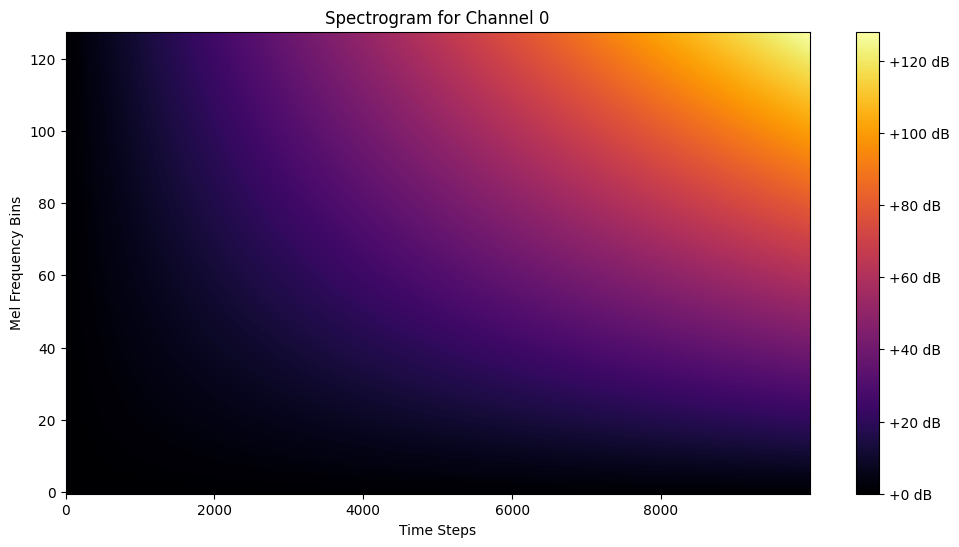

In [26]:
'''# Choose a channel to plot
channel_to_plot = 0  # Change this index to view different channels

# Extract data for the chosen channel
spectrogram_data = data[:, :, channel_to_plot]

# Plot the spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(spectrogram_data.T, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram for Channel {channel_to_plot}')
plt.xlabel('Time Steps')
plt.ylabel('Mel Frequency Bins')
plt.show()'''

In [21]:
customModel.config

ASTConfig {
  "attention_probs_dropout_prob": 0.0,
  "frequency_stride": 10,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_values": [
    40000,
    128,
    8
  ],
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 1024,
  "model_type": "audio-spectrogram-transformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_mel_bins": 128,
  "patch_size": 16,
  "qkv_bias": true,
  "time_stride": 10,
  "transformers_version": "4.44.0"
}